In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV, train_test_split

df = pd.read_csv('data.csv')

X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, mae, r2

def print_metrics(mse, mae, r2):
    print(f'MSE: {mse:.3f}')
    print(f'MAE: {mae:.3f}')
    print(f'R2: {r2:.3f}')

# Random Forest

## Default parameters

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from category_encoders import TargetEncoder

pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=['nationality'])),
    ('model', RandomForestRegressor(random_state=42))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('encoder', TargetEncoder(cols=['nationality'])),
                ('model', RandomForestRegressor(random_state=42))])

In [75]:
features_importance = pipeline.named_steps['model'].feature_importances_

feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': features_importance
})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df = importance_df.reset_index(drop=True)
importance_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
feature,ball_control,age,standing_tackle,interceptions,nationality,positioning,vision,heading_accuracy,marking,finishing,crossing,stamina,shot_power,jumping,short_passing,sliding_tackle,strength,sprint_speed,aggression,dribbling,agility,acceleration,long_shots,long_passing,volleys,weight_kgs,penalties,height_cm,skill_moves(1-5),curve,balance,freekick_accuracy,positions_GK,weak_foot(1-5),preferred_foot,positions_CM,body_type_Lean,body_type_Normal,body_type_Stocky,positions_CAM,positions_CDM,positions_LM,positions_RM,positions_RB,positions_LB,positions_CB,positions_ST,positions_RW,positions_LW,positions_CF,positions_LWB,positions_RWB
importance,0.464013,0.149378,0.095563,0.041145,0.032618,0.028332,0.01772,0.017522,0.016236,0.009811,0.008815,0.008686,0.008638,0.008569,0.008011,0.007465,0.007302,0.007009,0.005978,0.005933,0.005033,0.004982,0.004912,0.004666,0.004437,0.003872,0.003847,0.003208,0.002943,0.002928,0.002698,0.002576,0.001303,0.001241,0.000401,0.000373,0.00034,0.00033,0.000181,0.00016,0.000119,0.00011,0.0001,0.000095,0.000091,0.000077,0.000062,0.000048,0.000044,0.000034,0.000024,0.000024


In [28]:
mse_train, mae_train, r2_train = evaluate_model(pipeline, X_train, y_train)
print('Training set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(pipeline, X_test, y_test)
print('\nTest set:')
print_metrics(mse_test, mae_test, r2_test)

Training set:
MSE: 0.628
MAE: 0.513
R2: 0.987

Test set:
MSE: 4.123
MAE: 1.355
R2: 0.914


In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

mse_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
mse_scores = -mse_scores
print(f"MSE: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

mae_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores: [0.91614328 0.91188125 0.91387626 0.90390466 0.90756792]
R^2 trung bình: 0.911 ± 0.004

MSE: [4.07758627 4.23785841 4.16927205 4.53868537 4.53839036]
MSE trung bình: 4.312± 0.192

MAE: [1.34950139 1.33275487 1.34244079 1.38802452 1.38643076]
MAE trung bình: 1.360 ± 0.023


## GA to find optimal parameters

In [60]:
def create_individual():
    n_estimators = np.random.randint(100, 350)
    max_depth = np.random.randint(5, 25)
    min_samples_split = np.random.randint(2, 100)
    max_features = np.random.choice(['sqrt', 'log2', None])
    return [n_estimators, max_depth, min_samples_split, max_features]

def fitness(individual):
    n_estimators, max_depth, min_samples_split, max_features = individual
    model = Pipeline([
        ('te', TargetEncoder(cols=['nationality'])),
        ('rf', RandomForestRegressor(
            n_estimators=n_estimators, 
            max_depth=max_depth, 
            min_samples_split=min_samples_split, 
            max_features=max_features, 
            random_state=42
        ))
    ])

    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    return -scores.mean(),

def create_population(pop_size):
    return [create_individual() for _ in range(pop_size)]

def crossover(ind1, ind2, crossover_rate=0.9):
    child1, child2 = ind1[:], ind2[:]
    if np.random.rand() < crossover_rate:
        crossover_point = np.random.randint(1, len(ind1))
        child1 = ind1[:crossover_point] + ind2[crossover_point:]
        child2 = ind2[:crossover_point] + ind1[crossover_point:]
    return child1, child2

def mutate(individual, muatate_rate=0.05):
    mutated = individual[:]
    for i in range(len(mutated)):
        if np.random.rand() < muatate_rate:
            mutated[i] = create_individual()[i]
    return mutated

In [61]:
def GA(pop_size, generations, generations_values, fitness_values):
    population = create_population(pop_size)

    for generation in range(generations):
        scores = [fitness(ind) for ind in population]
        sorted_population = [ind for ind, score in sorted(zip(population, scores), key=lambda x: x[1])]

        print(f'Generation {generation + 1}: Best MSE: {scores[0][0]:.3f}')
        print(f'Solution: {sorted_population[0]}')
        
        generations_values.append(generation + 1)
        fitness_values.append(scores[0][0])

        # Elitism
        parents = sorted_population[:5]
        next_generation = parents[:]

        while len(next_generation) < pop_size:
            # Selection
            idx1 = np.random.randint(0, len(parents))
            while True:
                idx2 = np.random.randint(0, len(parents))
                if idx2 != idx1:
                    break
            parent1, parent2 = parents[idx1], parents[idx2]

            # Crossover
            child1, child2 = crossover(parent1, parent2)

            # Mutation
            child1 = mutate(child1)
            child2 = mutate(child2)

            next_generation.extend([child1, child2])

        population = next_generation
    
    scores = [fitness(ind) for ind in population]
    sorted_population = [ind for ind, score in sorted(zip(population, scores), key=lambda x: x[1])]
    return sorted_population[0]

In [62]:
pop_size = 50
generations = 50

generation_values = []
fitness_values = []

best_individual = GA(pop_size, generations, generation_values, fitness_values)
best_individual

Generation 1: Best MSE: 10.179
Solution: [143, 13, 3, 'sqrt']
Generation 2: Best MSE: 4.328
Solution: [198, 22, 3, 'sqrt']
Generation 3: Best MSE: 4.107
Solution: [198, 22, 3, 'sqrt']
Generation 4: Best MSE: 4.107
Solution: [332, 22, 3, 'sqrt']
Generation 5: Best MSE: 4.095
Solution: [332, 23, 3, 'sqrt']
Generation 6: Best MSE: 4.091
Solution: [332, 23, 3, 'sqrt']
Generation 7: Best MSE: 4.091
Solution: [332, 23, 3, 'sqrt']
Generation 8: Best MSE: 4.091
Solution: [332, 23, 3, 'sqrt']
Generation 9: Best MSE: 4.091
Solution: [332, 23, 3, 'sqrt']
Generation 10: Best MSE: 4.091
Solution: [321, 23, 3, 'sqrt']
Generation 11: Best MSE: 4.091
Solution: [321, 23, 3, 'sqrt']
Generation 12: Best MSE: 4.091
Solution: [321, 23, 3, 'sqrt']
Generation 13: Best MSE: 4.091
Solution: [321, 23, 3, 'sqrt']
Generation 14: Best MSE: 4.091
Solution: [321, 23, 3, 'sqrt']
Generation 15: Best MSE: 4.091
Solution: [321, 23, 3, 'sqrt']
Generation 16: Best MSE: 4.091
Solution: [321, 23, 3, 'sqrt']
Generation 17: B

[341, 20, 3, 'sqrt']

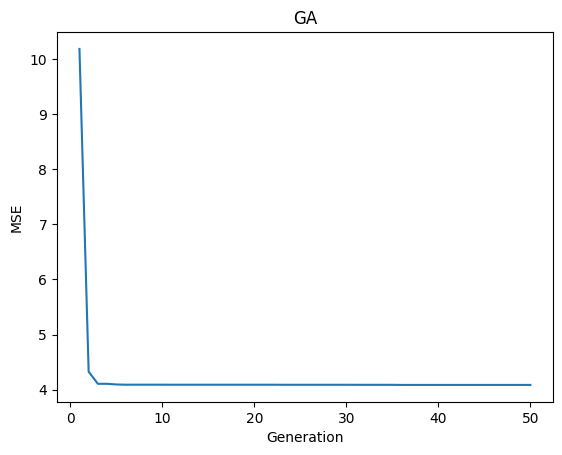

In [66]:
import matplotlib.pyplot as plt

plt.plot(generation_values, fitness_values)
plt.xlabel('Generation')
plt.ylabel('MSE')
plt.title('GA')
plt.show()

In [97]:
model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('rf', RandomForestRegressor(
        n_estimators=best_individual[0], 
        max_depth=best_individual[1], 
        min_samples_split=best_individual[2], 
        max_features=best_individual[3], 
        random_state=42
    ))
])
model.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('rf',
                 RandomForestRegressor(max_depth=20, max_features='sqrt',
                                       min_samples_split=3, n_estimators=341,
                                       random_state=42))])

### Feature Importance in RF

In [98]:
features_importance = model.named_steps['rf'].feature_importances_

feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': features_importance
})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df = importance_df.reset_index(drop=True)
importance_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
feature,ball_control,short_passing,age,dribbling,interceptions,standing_tackle,positioning,vision,sliding_tackle,marking,shot_power,long_shots,long_passing,heading_accuracy,nationality,crossing,finishing,aggression,skill_moves(1-5),strength,volleys,stamina,curve,jumping,sprint_speed,weight_kgs,acceleration,agility,penalties,freekick_accuracy,positions_GK,balance,height_cm,weak_foot(1-5),positions_CB,positions_CM,body_type_Lean,body_type_Normal,preferred_foot,positions_ST,positions_CDM,body_type_Stocky,positions_LB,positions_LM,positions_RM,positions_CAM,positions_RB,positions_LW,positions_RW,positions_CF,positions_RWB,positions_LWB
importance,0.118918,0.073772,0.068869,0.061004,0.057124,0.054964,0.054081,0.047414,0.041291,0.038189,0.035855,0.03272,0.031202,0.029797,0.023262,0.022265,0.020453,0.019641,0.019481,0.019229,0.018274,0.015795,0.013439,0.011981,0.009823,0.009297,0.008854,0.007835,0.007141,0.006295,0.004601,0.004432,0.004313,0.0015,0.001148,0.001088,0.000712,0.000648,0.000552,0.000504,0.000345,0.000317,0.000247,0.000239,0.000234,0.000224,0.000219,0.00011,0.000107,0.000079,0.000059,0.000053


In [99]:
# importance_columns = importance_df['feature'][:35]

# X_train_selected = X_train[importance_columns]
# X_test_selected = X_test[importance_columns]

# model = Pipeline([
#     ('encoder', TargetEncoder(cols=['nationality'])),
#     ('model', RandomForestRegressor(
#         n_estimators=best_individual[0], 
#         max_depth=best_individual[1], 
#         min_samples_split=best_individual[2], 
#         max_features=best_individual[3], 
#         random_state=42
#     ))
# ])

# model.fit(X_train_selected, y_train)

In [100]:
# mse_train, mae_train, r2_train = evaluate_model(model, X_train_selected, y_train)
# print('Training set:')
# print_metrics(mse_train, mae_train, r2_train)

# mse_test, mae_test, r2_test = evaluate_model(model, X_test_selected, y_test)
# print('\nTest set:')
# print_metrics(mse_test, mae_test, r2_test)

### Evaluate GA tree

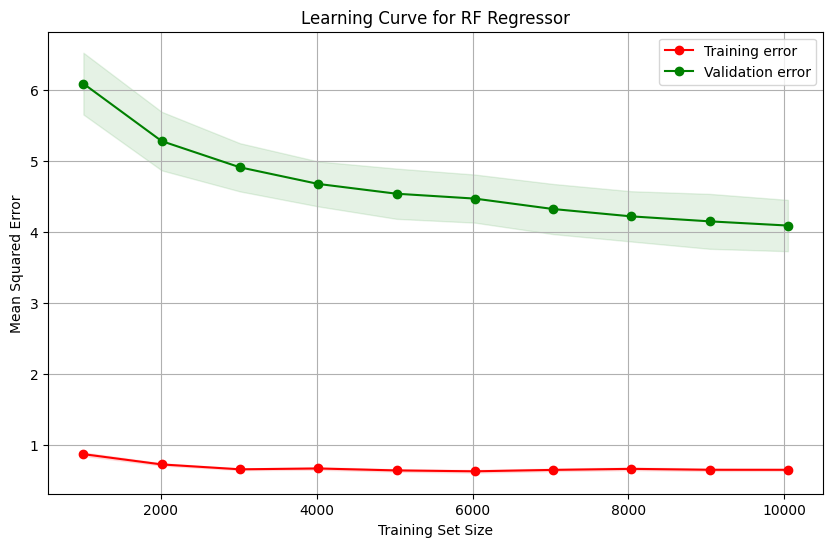

In [70]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model,
    X_train,
    y_train,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve for RF Regressor")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training error")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation error")

plt.legend(loc="best")
plt.grid()
plt.show()

In [65]:
mse_train, mae_train, r2_train = evaluate_model(model, X_train, y_train)
print('Training set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(model, X_test, y_test)
print('\nTest set:')
print_metrics(mse_test, mae_test, r2_test)

Training set:
MSE: 0.648
MAE: 0.502
R2: 0.987

Test set:
MSE: 3.800
MAE: 1.256
R2: 0.921


In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
mse_scores = -mse_scores
print(f"MSE: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

mae_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores: [0.924307   0.91911419 0.92301859 0.91410665 0.91465345]
R^2 trung bình: 0.919 ± 0.004

MSE: [3.68062023 3.89000736 3.7266898  4.05683475 4.1904927 ]
MSE trung bình: 3.909± 0.193

MAE: [1.24755251 1.22664417 1.21859894 1.2698906  1.28530086]
MAE trung bình: 1.250 ± 0.025


# AdaBoost

### Train AdaBoost in which base estimator used is Decision Stump (A node with 2 leaves)

In [6]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=['nationality'])),
    ('model', AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=1, random_state=42),
        random_state=42,
    ))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('encoder', TargetEncoder(cols=['nationality'])),
                ('model',
                 AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=1,
                                                                   random_state=42),
                                   random_state=42))])

In [7]:
mse_train, mae_train, r2_train = evaluate_model(pipeline, X_train, y_train)
print('Training set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(pipeline, X_test, y_test)
print('\nTest set:')
print_metrics(mse_test, mae_test, r2_test)

Training set:
MSE: 24.408
MAE: 3.911
R2: 0.496

Test set:
MSE: 24.566
MAE: 3.934
R2: 0.490


In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

mse_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
mse_scores = -mse_scores
print(f"MSE: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

mae_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores: [0.48452958 0.48344657 0.492958   0.49629003 0.48400428]
R^2 trung bình: 0.488 ± 0.005

MSE: [25.06507711 24.84238816 24.54603203 23.79075923 25.33525242]
MSE trung bình: 24.716± 0.530

MAE: [3.99500652 3.96021792 3.88579831 3.87882684 3.97654795]
MAE trung bình: 3.939 ± 0.048


### Tuning n_estimators in Ada

In [ ]:
pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=['nationality'])),
    ('model', AdaBoostRegressor(
        estimator=DecisionTreeRegressor(
            max_depth=1, 
            random_state=42
        ),
        random_state=42,
        n_estimators=20
    ))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('encoder', TargetEncoder(cols=['nationality'])),
                ('model',
                 AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=1,
                                                                   random_state=42),
                                   n_estimators=20, random_state=42))])

In [28]:
mse_train, mae_train, r2_train = evaluate_model(pipeline, X_train, y_train)
print('Training set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(pipeline, X_test, y_test)
print('\nTest set:')
print_metrics(mse_test, mae_test, r2_test)

Training set:
MSE: 23.402
MAE: 3.792
R2: 0.516

Test set:
MSE: 23.547
MAE: 3.809
R2: 0.511


In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

mse_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
mse_scores = -mse_scores
print(f"MSE: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

mae_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores: [0.50895449 0.50562182 0.50567674 0.51512057 0.49037572]
R^2 trung bình: 0.505 ± 0.008

MSE: [23.87740038 23.77592334 23.93031461 22.90137297 25.02241634]
MSE trung bình: 23.901± 0.674

MAE: [3.82490202 3.82053767 3.79279243 3.770779   3.91299787]
MAE trung bình: 3.824 ± 0.048


In [ ]:
from sklearn.linear_model import LinearRegression

pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=['nationality'])),
    ('scaler', StandardScaler()),
    ('model', AdaBoostRegressor(
        estimator=DecisionTreeRegressor(random_state=42, max_depth=17, ccp_alpha=0.0004872495324492965,
                                        min_samples_split=35, min_samples_leaf=9),
        random_state=42,
        n_estimators=30,
        # learning_rate=1
    ))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('encoder', TargetEncoder(cols=['nationality'])),
                ('scaler', StandardScaler()),
                ('model',
                 AdaBoostRegressor(estimator=DecisionTreeRegressor(ccp_alpha=0.0004872495324492965,
                                                                   max_depth=17,
                                                                   min_samples_leaf=9,
                                                                   min_samples_split=35,
                                                                   random_state=42),
                                   learning_rate=1, n_estimators=30,
                                   random_state=42))])

In [62]:
mse_train, mae_train, r2_train = evaluate_model(pipeline, X_train, y_train)
print('Training set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(pipeline, X_test, y_test)
print('\nTest set:')
print_metrics(mse_test, mae_test, r2_test)

Training set:
MSE: 0.952
MAE: 0.806
R2: 0.980

Test set:
MSE: 4.337
MAE: 1.412
R2: 0.910


In [49]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

mse_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
mse_scores = -mse_scores
print(f"MSE: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

mae_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores: [0.91254409 0.90865086 0.90854263 0.89727926 0.90173788]
R^2 trung bình: 0.906 ± 0.005

MSE: [4.2525995  4.39321584 4.42747478 4.85161016 4.82464376]
MSE trung bình: 4.550± 0.243

MAE: [1.40317666 1.40002714 1.39171982 1.44835767 1.46612277]
MAE trung bình: 1.422 ± 0.030


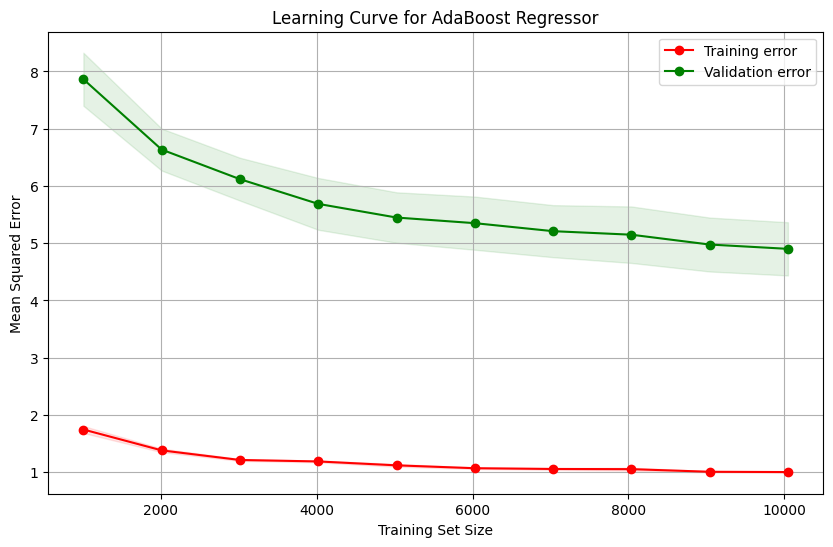

In [52]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    pipeline,
    X_train,
    y_train,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve for AdaBoost Regressor")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training error")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation error")

plt.legend(loc="best")
plt.grid()
plt.show()

# Gradient Boosting

In [43]:
from sklearn.ensemble import GradientBoostingRegressor

pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=['nationality'])),
    ('model', GradientBoostingRegressor(random_state=42))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('encoder', TargetEncoder(cols=['nationality'])),
                ('model', GradientBoostingRegressor(random_state=42))])

In [44]:
mse_train, mae_train, r2_train = evaluate_model(pipeline, X_train, y_train)
print('Training set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(pipeline, X_test, y_test)
print('\nTest set:')
print_metrics(mse_test, mae_test, r2_test)

Training set:
MSE: 4.255
MAE: 1.426
R2: 0.912

Test set:
MSE: 4.673
MAE: 1.494
R2: 0.903


In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

mse_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
mse_scores = -mse_scores
print(f"MSE: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

mae_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores: [0.90450224 0.90124555 0.90223681 0.89751659 0.8959926 ]
R^2 trung bình: 0.900 ± 0.003

MSE: [4.64363953 4.74935647 4.73274085 4.84040084 5.10673571]
MSE trung bình: 4.815± 0.159

MAE: [1.49414369 1.46203673 1.48309778 1.51353161 1.5244586 ]
MAE trung bình: 1.495 ± 0.022


# XGBoost

In [46]:
from xgboost import XGBRegressor

pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=['nationality'])),
    ('model', XGBRegressor(random_state=42))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('encoder', TargetEncoder(cols=['nationality'])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [47]:
mse_train, mae_train, r2_train = evaluate_model(pipeline, X_train, y_train)
print('Training set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(pipeline, X_test, y_test)
print('\nTest set:')
print_metrics(mse_test, mae_test, r2_test)

Training set:
MSE: 0.572
MAE: 0.568
R2: 0.988

Test set:
MSE: 4.149
MAE: 1.293
R2: 0.914


In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

mse_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
mse_scores = -mse_scores
print(f"MSE: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

mae_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores: [0.9228183  0.91458392 0.92128962 0.90739095 0.91773427]
R^2 trung bình: 0.917 ± 0.005

MSE: [3.75300903 4.10787969 3.81038844 4.37402307 4.03922523]
MSE trung bình: 4.017± 0.223

MAE: [1.24758467 1.2554445  1.23411758 1.27945986 1.27133203]
MAE trung bình: 1.258 ± 0.016


# LightGBM

In [58]:
from lightgbm import LGBMRegressor

pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=['nationality'])),
    ('model', LGBMRegressor(random_state=42))
])
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2777
[LightGBM] [Info] Number of data points in the train set: 12562, number of used features: 52
[LightGBM] [Info] Start training from score 66.253781


Pipeline(steps=[('encoder', TargetEncoder(cols=['nationality'])),
                ('model', LGBMRegressor(random_state=42))])

In [59]:
mse_train, mae_train, r2_train = evaluate_model(pipeline, X_train, y_train)
print('Training set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(pipeline, X_test, y_test)
print('\nTest set:')
print_metrics(mse_test, mae_test, r2_test)

Training set:
MSE: 1.646
MAE: 0.922
R2: 0.966

Test set:
MSE: 3.496
MAE: 1.195
R2: 0.927
